In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from scipy import signal
import pywt

import os
import time
import datetime
import random
import h5py
import pickle

from ggs import *

from tensorflow.keras import models
from sklearn.preprocessing import LabelEncoder

from platform import python_version
print(python_version())

3.8.8


# Read and Prepare Data

In [3]:
def readData(accDir, annotFile):
    files = os.listdir(accDir)
    files_csv = [f for f in files if f[-3:] == 'csv']
    empatica_dict = dict()
    for f in files_csv:
        data = np.genfromtxt(accDir+f, delimiter=',') # creates numpy array for each Empatica acc csv file
        key = int(float(f.strip("ACC.csv")))
        empatica_dict[key] = data
    tmp = pd.read_excel(annotFile, sheet_name=None)
    annot_dict = dict(zip(tmp.keys(), [i.dropna() for i in tmp.values()])) # Remove the rows with NaN values (some with ladder 2 missing)
    return empatica_dict, annot_dict

def getLabeledDict(empatica_dict, annot_dict, subject_ids):
    labeled_dict = {}; taskInd_dict = {}
    for id in subject_ids:
        start_time = int(empatica_dict[id][0,0])
        acc = empatica_dict[id][2:,:]
        label = list(map(lambda i: i.replace("_end", "").replace("_start", ""), annot_dict['P'+ str(id)].taskName.tolist()))
        task_time= list(map(lambda i: time.mktime(datetime.datetime.strptime(i[:6] + '20' + i[6:], "%m/%d/%Y %H:%M:%S").timetuple()),
                            annot_dict['P'+ str(id)].startTime_global.tolist()))
        task_ind = [int(x - start_time)*SR for x in task_time]
        taskInd_dict[id] = task_ind
        label_tmp = np.empty(acc.shape[0], dtype=object)
        for i, (j, k) in enumerate(zip(task_ind[0::2], task_ind[1::2])):
            tmpInd = 2*i
            label_tmp[j:k] = label[tmpInd]
        acc_mag = np.sqrt(np.sum(acc**2, axis=1))[:,None]
        accel = np.hstack((acc, acc_mag))
        labeled_dict[id] = pd.DataFrame(np.hstack((accel, label_tmp.reshape(label_tmp.shape[0],1))), columns=['X', 'Y', 'Z', 'Mag', 'label'])
    return labeled_dict, taskInd_dict

In [4]:
sepAccDict, sepAnnotDict = readData(accDir='./Data/50_subs/Acc Data/separate/', annotFile='./Data/50_subs/Annotation Data/separate.xlsx')
SR=int(sepAccDict[8][1,0])

sepSubIDs = list(range(8,45))
sepSubIDs.remove(27) # does not have lift
sepLabeledDict_, sepTaskIndDict = getLabeledDict(sepAccDict, sepAnnotDict, sepSubIDs)

## Apply Low Pass Filter

In [5]:
# Apply Filter on All Subjects
n=4; fc=2; w=fc/(SR/2)
b, a = signal.butter(n, w, 'low')
sepLabeledDict_filtered = dict(map(lambda key: (key, signal.filtfilt(b, a, x=sepLabeledDict_[key].drop(columns='label'), axis=0)), sepLabeledDict_.keys()))
# back to DF and add label
sepLabeledDict_filtered_dfs = dict(map(lambda key: (
                                                        key, pd.DataFrame(sepLabeledDict_filtered[key],columns=['X', 'Y', 'Z', 'Mag']).assign(label=sepLabeledDict_[key].label)
                                                    ), sepLabeledDict_filtered.keys()))
# Remove data without label
filt_noNA_dict = dict(map(lambda key: (key, sepLabeledDict_filtered_dfs[key].dropna()), sepLabeledDict_filtered_dfs.keys()))

In [5]:
winLen = 320
window_dict = {}
label_dict = {}
for key in filt_noNA_dict.keys():
    window_list = []
    labels=[]
    for g1, df1 in filt_noNA_dict[key].groupby('label'):
        for g2, df2 in df1.groupby(np.arange(df1.shape[0]) // winLen):
            if df2.shape[0]==winLen:
                window_list.append(df2.drop(columns=['Mag', 'label']))
                labels.append(g1)
    window_dict[key] = np.array(window_list)
    label_dict[key] = labels

In [325]:
filt_noNA_dict[16].label.unique()

array(['sit', 'stand', 'walk', 'hoist', 'lift', 'push', 'type', 'ladder1',
       'ladder2', 'electricPanel', 'overhead'], dtype=object)

In [191]:
window_dict[8].shape

(187, 320, 3)

In [194]:
len(label_dict[8])

187

## Load and Correct GGS Segments

In [276]:
segments = pd.read_pickle('segments.pickle')
new_seg_dict = {}
for sub in segments.keys():
    segment = segments[sub]
    seg = segment[-1]
    new_segment = []
    
    thresh = 960 # ensure 30 seconds between segments
    idx = np.where(np.diff(seg) < thresh)[0]
    cluster_idxs_ = np.split(idx, np.where(np.diff(idx) != 1)[0]+1)
    clusters_idxs = [np.append(elem, max(elem) + 1) for elem in cluster_idxs_]
    cluster_vals = [np.array(seg)[idxs] for idxs in clusters_idxs]

    new_segs = list(set(seg) - set(np.concatenate(cluster_vals)))
    for elem in cluster_vals:
        if any(elem==0):
            new_segs.append(0)
        elif any(elem==seg[-1]):
            new_segs.append(seg[-1])
        else:
            for early_seg in segment:
                if any((np.array(early_seg)>(min(elem) - 30)) & (np.array(early_seg)<(max(elem) + 30))):
                    replacement = min(np.array(early_seg)[(np.array(early_seg)>(min(elem) - 30)) & (np.array(early_seg)<(max(elem) + 30))])
                    new_segs.append(replacement)
                    break
    new_seg_dict[sub] = sorted(new_segs)

# Test the Pipeline on Subjects: 8, 9, 10, 11

**Steps:**

> 1- Extract windows of `10 seconds` within each segment

> 2- Perform continuous wavelet transform (`CWT`) in each window (extract features)

> 3- Classify each window using the trained `CNN` model

> 4- Classify each segment by `voting`

> 5- Modify the segments by `merging neighboring windows` of same class

> 6- `Count` the repititions in lifting and walking windows

# Load the trained model

In [330]:
model = models.load_model('./tf_model/')
labels_categorical = ['sit', 'stand', 'walk', 'hoist', 'lift', 'push', 'type', 'ladder', 'electricPanel', 'overhead']
labels_encoded = LabelEncoder().fit_transform(labels_categorical).tolist()
labels_dict = dict([(numeric_, categorical_) for numeric_, categorical_ in zip(labels_encoded, labels_categorical)])

In [333]:
########### Load test subject numbers
with open('test_subs.pickle', 'rb') as infile:
    test_subs = pickle.load(infile)

In [334]:
sorted(test_subs)

[8, 12, 14, 20, 24, 29, 31, 39]

## Subject 8

In [332]:
sub = 8
segs = new_seg_dict[sub]
tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'ladder1']
sig_ = filt_noNA_dict[sub]
sig = sig_[sig_.label.isin(tasks)]

winLen = 320
scales = range(1,winLen)
waveletname = 'morl'
cwt_dict = {}
for i in range(len(segs)-1):
    ########### create window of length 320
    signal_seg = sig.iloc[segs[i]:segs[i+1],:3]
    window_list = []
    for g, df in signal_seg.groupby(np.arange(signal_seg.shape[0]) // winLen):
        if df.shape[0]==winLen:
            window_list.append(df.values)
    window_np = np.array(window_list)
    ########### cwt transform
    cwt_dict[i] = np.zeros(shape=(window_np.shape[0], winLen-1, winLen-1, 3), dtype=np.float)
    for j in range(window_np.shape[0]):
        for k in range(window_np.shape[2]):
            tmp_sig = window_np[j,:,k]
            coeff, freq = pywt.cwt(tmp_sig, scales, waveletname, 1/SR)
            cwt_dict[i][j, :, :, k] = coeff[:, :-1]

## Get Label for each Segment

In [335]:
############## predict labels within each segment using the trained model and voting
pred_label = dict()
for key in cwt_dict.keys():
    OH_pred = model.predict(cwt_dict[key]/np.max(cwt_dict[key]))
    numeric_pred = np.argmax(OH_pred, axis=1)
    most_frequent = np.bincount(numeric_pred).argmax()
    pred_label[key] = labels_dict[most_frequent]

############## remove segmenets for same neighbouring labels
labels = list(pred_label.values())
new_segs = [segs[0], segs[-1]]
new_labels = [labels[0]]
for i in range(len(labels[:-1])):
    if labels[i] != labels[i+1]:
        new_segs.append(segs[i+1])
        new_labels.append(labels[i+1])
new_segs = sorted(new_segs)

## Plot Data with Predicted Label at each Segment

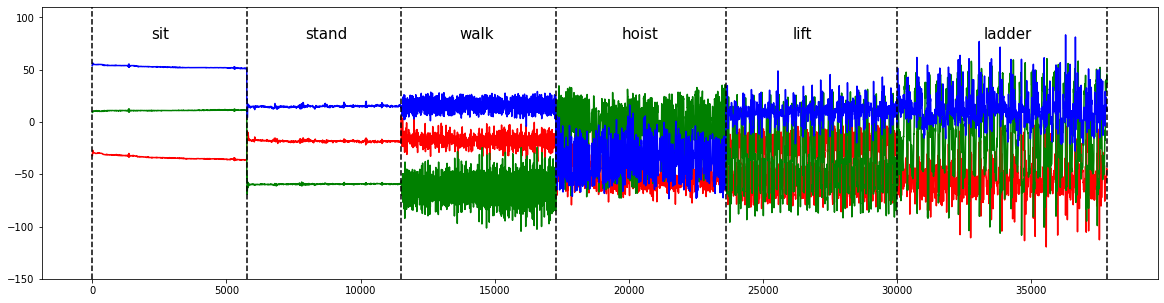

In [336]:
f, ax = plt.subplots(1, figsize=(20,5))
# ax.plot(sig.values[:,:3])
ax.plot(sig.values[:,0], c='r')
ax.plot(sig.values[:,1], c='g')
ax.plot(sig.values[:,2], c='b')
for v in new_segs:
    ax.axvline(v, c='k', linestyle = '--')
ax.set_ylim([-150, 110])
text_locs = (np.array(new_segs[:-1]) + np.array(new_segs[1:])) // 2
for loc, label in zip(text_locs, new_labels):
    ax.text(loc-700, 80, label, fontsize=15)
plt.show()

# Subject 12

In [344]:
sub = 12
segs = new_seg_dict[sub]
tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'ladder1']
sig_ = filt_noNA_dict[sub]
sig = sig_[sig_.label.isin(tasks)]

winLen = 320
scales = range(1,winLen)
waveletname = 'morl'
cwt_dict = {}
for i in range(len(segs)-1):
    ########### create window of length 320
    signal_seg = sig.iloc[segs[i]:segs[i+1],:3]
    window_list = []
    for g, df in signal_seg.groupby(np.arange(signal_seg.shape[0]) // winLen):
        if df.shape[0]==winLen:
            window_list.append(df.values)
    window_np = np.array(window_list)
    ########### cwt transform
    cwt_dict[i] = np.zeros(shape=(window_np.shape[0], winLen-1, winLen-1, 3), dtype=np.float)
    for j in range(window_np.shape[0]):
        for k in range(window_np.shape[2]):
            tmp_sig = window_np[j,:,k]
            coeff, freq = pywt.cwt(tmp_sig, scales, waveletname, 1/SR)
            cwt_dict[i][j, :, :, k] = coeff[:, :-1]

In [345]:
############## predict labels within each segment using the trained model and voting
pred_label = dict()
for key in cwt_dict.keys():
    OH_pred = model.predict(cwt_dict[key]/np.max(cwt_dict[key]))
    numeric_pred = np.argmax(OH_pred, axis=1)
    most_frequent = np.bincount(numeric_pred).argmax()
    pred_label[key] = labels_dict[most_frequent]

############## remove segmenets for same neighbouring labels
labels = list(pred_label.values())
new_segs = [segs[0], segs[-1]]
new_labels = [labels[0]]
for i in range(len(labels[:-1])):
    if labels[i] != labels[i+1]:
        new_segs.append(segs[i+1])
        new_labels.append(labels[i+1])
new_segs = sorted(new_segs)

In [352]:
new_labels

['sit', 'stand', 'walk', 'hoist', 'lift']

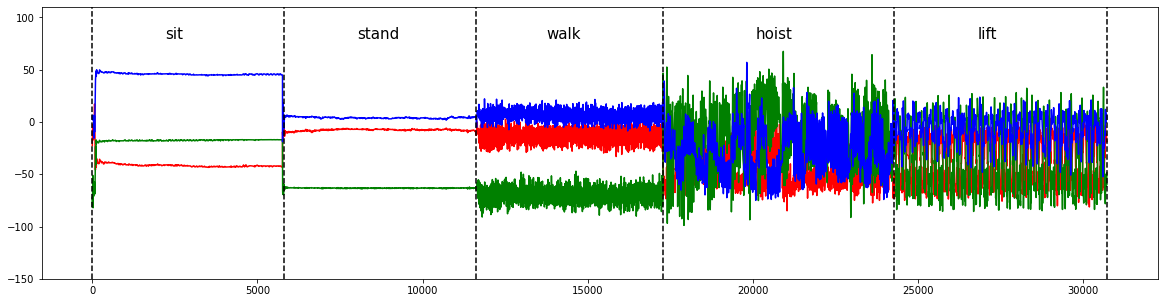

In [353]:
f, ax = plt.subplots(1, figsize=(20,5))
# ax.plot(sig.values[:,:3])
ax.plot(sig.values[:,0], c='r')
ax.plot(sig.values[:,1], c='g')
ax.plot(sig.values[:,2], c='b')
for v in new_segs:
    ax.axvline(v, c='k', linestyle = '--')
ax.set_ylim([-150, 110])
text_locs = (np.array(new_segs[:-1]) + np.array(new_segs[1:])) // 2
for loc, label in zip(text_locs, new_labels):
    ax.text(loc-700, 80, label, fontsize=15)
plt.show()

# Subject 20

In [340]:
sub = 20
segs = new_seg_dict[sub]
tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'ladder1']
sig_ = filt_noNA_dict[sub]
sig = sig_[sig_.label.isin(tasks)]

winLen = 320
scales = range(1,winLen)
waveletname = 'morl'
cwt_dict = {}
for i in range(len(segs)-1):
    ########### create window of length 320
    signal_seg = sig.iloc[segs[i]:segs[i+1],:3]
    window_list = []
    for g, df in signal_seg.groupby(np.arange(signal_seg.shape[0]) // winLen):
        if df.shape[0]==winLen:
            window_list.append(df.values)
    window_np = np.array(window_list)
    ########### cwt transform
    cwt_dict[i] = np.zeros(shape=(window_np.shape[0], winLen-1, winLen-1, 3), dtype=np.float)
    for j in range(window_np.shape[0]):
        for k in range(window_np.shape[2]):
            tmp_sig = window_np[j,:,k]
            coeff, freq = pywt.cwt(tmp_sig, scales, waveletname, 1/SR)
            cwt_dict[i][j, :, :, k] = coeff[:, :-1]

In [348]:
type(cwt_dict[key]), cwt_dict[key].shape

(numpy.ndarray, (20, 319, 319, 3))

In [341]:
############## predict labels within each segment using the trained model and voting
pred_label = dict()
for key in cwt_dict.keys():
    OH_pred = model.predict(cwt_dict[key]/np.max(cwt_dict[key]))
    numeric_pred = np.argmax(OH_pred, axis=1)
    most_frequent = np.bincount(numeric_pred).argmax()
    pred_label[key] = labels_dict[most_frequent]

############## remove segmenets for same neighbouring labels
labels = list(pred_label.values())
new_segs = [segs[0], segs[-1]]
new_labels = [labels[0]]
for i in range(len(labels[:-1])):
    if labels[i] != labels[i+1]:
        new_segs.append(segs[i+1])
        new_labels.append(labels[i+1])
new_segs = sorted(new_segs)

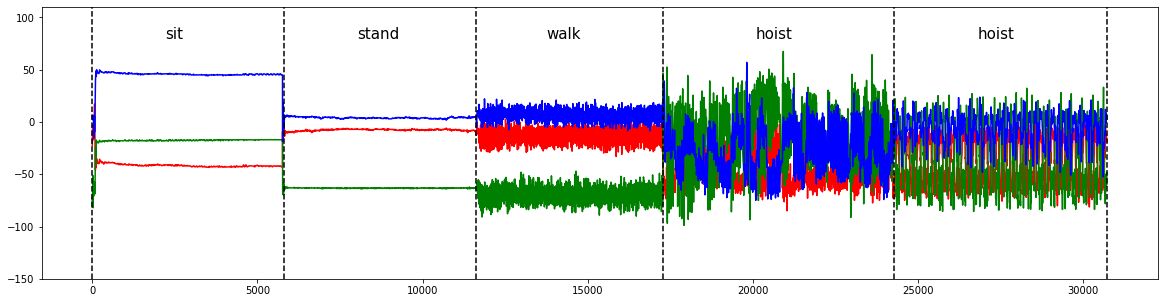

In [350]:
f, ax = plt.subplots(1, figsize=(20,5))
# ax.plot(sig.values[:,:3])
ax.plot(sig.values[:,0], c='r')
ax.plot(sig.values[:,1], c='g')
ax.plot(sig.values[:,2], c='b')
for v in new_segs:
    ax.axvline(v, c='k', linestyle = '--')
ax.set_ylim([-150, 110])
text_locs = (np.array(new_segs[:-1]) + np.array(new_segs[1:])) // 2
for loc, label in zip(text_locs, pred_label.values()):
    ax.text(loc-700, 80, label, fontsize=15)
f.savefig('lift1.png')
plt.show()